# Own Capstone Project - Setting up Gym in Munich

## Introduction

The purpose of this project is to find a suitable neighborhood for opening up a new gym in the city of Munich (München), Germany, which is also a city where I live. With 1.5 mil inhabitants, Munich is the 3rd largest city in Germany. It contains 25 neighbhorhoods ("Stadtbezirke" in German).  

To solve this problem, I will combine three different data sources:
- the data from Foursquare API
- demographical data 
- the average private property rent accross neighborhoods

The subject interested in this analysis would be a subject wanting to open up a gym. 

### Data sources and extraction

#### Foursquare API
I will carry out the data extraction and use the codes as shown in this course. Later on I will only filter out the gym venues to see how many there are in each neighborhood.

#### Demographical Data
The demographical data is extracted from the statistical webiste of Munich city coucil.

Website link: http://www.mstatistik-muenchen.de/indikatorenatlas/export/export.htm

File link: http://www.mstatistik-muenchen.de/indikatorenatlas/export/mv_export_csv_ab2010.xlsx

It contains all sorts of demographic data from the years 2010 - 2017. From here I also extract the neighborhood names.
The data is in German but I will rename (translate into English) the columns that I am going to keep. 

#### Rental Data
I decided to add private property rental prices to my analysis as it reflects the wealth of the neighborhood. Areas with high rent will be more expensive to run a gym in but also have greater purchase power. Depending of what we want to offer, more expensive neigbhorhoods can afford luxury gyms with a variety of services, whether cheaper areas are more likely to accomodate a simple gym with lower membership fees. 

The data is show in form of table on the website of a real estate agent:
https://suedbayerische-immobilien.de/Mietpreise-Muenchen-Stadtteile
I will extract the data using Beautiful Soup.

### Computation and clustering
I will first calculate the number of population (potential customers) per gym. As potential customer base I consider the population at the age of 15 - 65 years of age as this is the age group where most gym customers tend to fall into.

Then I will obtain the percentage of children under the age of 6 out of total population. This is an important measure, if we consider opening up a gym with child minding facilities. That would entices more customers who have chidren as the sport in the gym will be more accessible to them.

The plan is to segment the neighburhoods into clusters using K-means clustering algorithm. The inputs will be the number of population per gym, percentage of small children and the wealthiness of the neighborhood. That way we will be able to see which areas most likely to welcome a new gym and what kind of gym that would be.

In [4]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder
import folium
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Obtaining neighborhood names and coordinates

First we extract the neighborhood names from the Munich statistical dataset. We will be using the sheet named BEVÖLKERUNG (Population). It's a large dataset so it will take a few seconds to read.

In [7]:
path = 'http://www.mstatistik-muenchen.de/indikatorenatlas/export/mv_export_csv_ab2010.xlsx'

df = pd.read_excel(path, sheet_name='BEVÖLKERUNG')
population = df[(df['Indikator']=='Altersgruppen') & (df['Gliederung']=='Stadtbezirk') & (df['Jahr']==2017)].dropna(axis=1)
population.head()

,Indikator,Ausprägung,Jahr,Gliederung,Nummer zur Gliederung,Name zur Gliederung,Indikatorwert,Basiswert 1,Name Basiswert 1
2608,Altersgruppen,Einwohnerzahl,2017,Stadtbezirk,23,23 Allach - Untermenzing,32677,32677.0,Einwohnerzahl
2609,Altersgruppen,Einwohnerzahl,2017,Stadtbezirk,21,21 Pasing - Obermenzing,74098,74098.0,Einwohnerzahl
2610,Altersgruppen,Einwohnerzahl,2017,Stadtbezirk,4,04 Schwabing - West,68265,68265.0,Einwohnerzahl
2611,Altersgruppen,Einwohnerzahl,2017,Stadtbezirk,10,10 Moosach,53662,53662.0,Einwohnerzahl
2612,Altersgruppen,Einwohnerzahl,2017,Stadtbezirk,25,25 Laim,56281,56281.0,Einwohnerzahl


In [4]:
# translate the column names from German to English
population.rename(columns={'Indikator':'Indicator', 'Ausprägung':'Characteristic', 'Jahr':'Year', 'Gliederung':'Area Segmentation', 'Nummer zur Gliederung':'Area Number', 'Name zur Gliederung':'Area Name', 
                           'Indikatorwert':'Indicator Value', 'Basiswert 1':'Base Value 1', 'Name Basiswert 1':'Base Name 1'}, inplace=True)
population.sort_values(['Characteristic', 'Area Name'], inplace=True)

In [7]:
# extract the neighborhoods names
neighborhoods_list = population['Area Name'].str[3:].unique().tolist()
neighborhoods_list

['Altstadt - Lehel',
 'Ludwigsvorstadt - Isarvorstadt',
 'Maxvorstadt',
 'Schwabing - West',
 'Au - Haidhausen',
 'Sendling',
 'Sendling - Westpark',
 'Schwanthalerhöhe',
 'Neuhausen - Nymphenburg',
 'Moosach',
 'Milbertshofen - Am Hart',
 'Schwabing - Freimann',
 'Bogenhausen',
 'Berg am Laim',
 'Trudering - Riem',
 'Ramersdorf - Perlach',
 'Obergiesing - Fasangarten',
 'Untergiesing - Harlaching',
 'Thalkirchen - Obersendling - Forstenried - Fürstenried - Solln',
 'Hadern',
 'Pasing - Obermenzing',
 'Aubing - Lochhausen - Langwied',
 'Allach - Untermenzing',
 'Feldmoching - Hasenbergl',
 'Laim']

In [8]:
# obtain the neighborhoods' coordinates using the geolocator library
neighborhood_lat = []
neighborhood_lon = []
for neig in neighborhoods_list:
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode('{}, Munich, Germany'.format(neig))
    
    neighborhood_lat.append(location.latitude)
    neighborhood_lon.append(location.longitude)  

In [9]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate a new dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [10]:
# input the lists into the new data frame columns
neighborhoods['Neighborhood'] = neighborhoods_list
neighborhoods['Latitude'] = neighborhood_lat
neighborhoods['Longitude'] = neighborhood_lon
neighborhoods

,Neighborhood,Latitude,Longitude
0,Altstadt - Lehel,48.137828,11.574582
1,Ludwigsvorstadt - Isarvorstadt,48.131771,11.555809
2,Maxvorstadt,48.146570,11.571445
3,Schwabing - West,48.164417,11.570364
4,Au - Haidhausen,48.128753,11.590536
5,Sendling,48.118012,11.539083
6,Sendling - Westpark,48.118031,11.519333
7,Schwanthalerhöhe,48.134230,11.539034
8,Neuhausen - Nymphenburg,48.154222,11.531517
9,Moosach,48.179895,11.510571


## Vizualise the neighborhoods

First obtain the coordinates of Munich using geopy.geocoders library.

In [11]:
address = 'Munich'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Munich are 48.1371079, 11.5753822.


Create the folium map of Munich neigborhoods.

In [12]:
# create map and display it
munich_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# loop through the 25 neighborhoods and add each to the map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=20, # define how big you want the circle markers to be
        color='purple',
        fill=True,
        popup=label,
        fill_color='orange',
        fill_opacity=0.6
    ).add_to(munich_map)

munich_map

## Explore neighborhoods in Munich using Foursquare API

Now we download the json file with the various venues from Foursquare API.




Define Foursquare Credentials and Version (this is a hidden cell):

In [13]:
# hidden_cell
CLIENT_ID = 'SVEWXBLGDUZYFRLDCI0CQXHTGHFUASSAK5G1CAFFNAPH5COZ' # your Foursquare ID
CLIENT_SECRET = '5G3KVAWC332CYBUDIRT45F3MGZJOWPSMAJU0ODVWA4TKQIM3' # your Foursquare Secret
VERSION = '20180410' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SVEWXBLGDUZYFRLDCI0CQXHTGHFUASSAK5G1CAFFNAPH5COZ
CLIENT_SECRET:5G3KVAWC332CYBUDIRT45F3MGZJOWPSMAJU0ODVWA4TKQIM3


In [14]:
LIMIT = 200

Here is a function to explore venues in all the neighborhoods in Munich and extract their location data.

In [17]:
# this code has been borrowed from the IBM Coursera course "Python for Data Science"
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['location']['formattedAddress'][0],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Street',
                             'Venue Category']
    
    return(nearby_venues)

Write the code to run the above function on each neighborhood and create a new dataframe called munich_venues.

In [18]:
munich_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Altstadt - Lehel
Ludwigsvorstadt - Isarvorstadt
Maxvorstadt
Schwabing - West
Au - Haidhausen
Sendling
Sendling - Westpark
Schwanthalerhöhe
Neuhausen - Nymphenburg
Moosach
Milbertshofen - Am Hart
Schwabing - Freimann
Bogenhausen
Berg am Laim
Trudering - Riem
Ramersdorf - Perlach
Obergiesing - Fasangarten
Untergiesing - Harlaching
Thalkirchen - Obersendling - Forstenried - Fürstenried - Solln
Hadern
Pasing - Obermenzing
Aubing - Lochhausen - Langwied
Allach - Untermenzing
Feldmoching - Hasenbergl
Laim


Let's check the size of the dataframe.

In [19]:
print(munich_venues.shape)
munich_venues.head()

(2257, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Street,Venue Category
0,Altstadt - Lehel,48.137828,11.574582,Marienplatz,48.137208,11.575358,Marienplatz,Plaza
1,Altstadt - Lehel,48.137828,11.574582,Alois Dallmayr,48.138554,11.576750,Dienerstr. 14-15,Gourmet Shop
2,Altstadt - Lehel,48.137828,11.574582,St. Peter,48.136530,11.575615,Rindermarkt 1,Church
3,Altstadt - Lehel,48.137828,11.574582,Fischbrunnen,48.137211,11.576047,Marienplatz,Fountain
4,Altstadt - Lehel,48.137828,11.574582,Viktualienmarkt,48.135296,11.576368,Viktualienmarkt 6,Farmers Market


Check what are the names of the unique categories of venues to be found in Munich. That will enable us to choose the right categories for our analysis.

In [20]:
munich_venues['Venue Category'].unique()

array(['Plaza', 'Gourmet Shop', 'Church', 'Fountain', 'Farmers Market',
       'German Restaurant', 'Candy Store', 'Irish Pub', 'Opera House',
       'Beer Garden', "Men's Store", 'Department Store', 'Hotel',
       'Clothing Store', 'Café', 'Falafel Restaurant', 'Coffee Shop',
       'Fish Market', 'Boutique', 'Pizza Place', 'Organic Grocery',
       'Breakfast Spot', 'Cocktail Bar', 'Art Museum', 'Bar', 'Bookstore',
       'Bavarian Restaurant', 'American Restaurant', 'Cupcake Shop',
       'Palace', 'Steakhouse', 'Jazz Club', 'English Restaurant',
       'Trattoria/Osteria', 'Garden', 'Wine Bar', 'Sporting Goods Shop',
       'Sandwich Place', 'Manti Place', 'Yoga Studio',
       'Monument / Landmark', 'Ice Cream Shop', 'Tea Room',
       'Seafood Restaurant', 'Spanish Restaurant', 'Pastry Shop',
       'Fast Food Restaurant', 'Art Gallery', 'Italian Restaurant',
       'Bistro', 'Indian Restaurant', 'Theater', 'Surf Spot',
       'Science Museum', 'Vietnamese Restaurant', 'Supermar

Now we extract only the venues named 'Gym' or 'Gym / Fintess Center'.

In [21]:
gyms = munich_venues[(munich_venues['Venue Category']=='Gym') | (munich_venues['Venue Category']=='Gym / Fitness Center')]
gyms.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Street,Venue Category
173,Ludwigsvorstadt - Isarvorstadt,48.131771,11.555809,Fitnessclub Sports & Health,48.122532,11.544660,Lindwurmstr. 114,Gym
373,Schwabing - West,48.164417,11.570364,Leo's Sports Club,48.155217,11.583177,Leopoldstraße 11,Gym
505,Sendling,48.118012,11.539083,Fitnessclub Sports & Health,48.122532,11.544660,Lindwurmstr. 114,Gym
551,Sendling,48.118012,11.539083,FitX,48.129677,11.532237,Hansastr. 60,Gym / Fitness Center
620,Sendling - Westpark,48.118031,11.519333,Fitnessclub Sports & Health,48.122532,11.544660,Lindwurmstr. 114,Gym


Some of the Venue Street names contain parentheses. As we are going to use these names for a geographical search later, we need to remove the parentheses to make the search easier.

In [22]:
gyms['Venue Street'] = gyms['Venue Street'].str.replace("\(.*\)","") # remove parentheses and their contents
gyms.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Street,Venue Category
173,Ludwigsvorstadt - Isarvorstadt,48.131771,11.555809,Fitnessclub Sports & Health,48.122532,11.544660,Lindwurmstr. 114,Gym
373,Schwabing - West,48.164417,11.570364,Leo's Sports Club,48.155217,11.583177,Leopoldstraße 11,Gym
505,Sendling,48.118012,11.539083,Fitnessclub Sports & Health,48.122532,11.544660,Lindwurmstr. 114,Gym
551,Sendling,48.118012,11.539083,FitX,48.129677,11.532237,Hansastr. 60,Gym / Fitness Center
620,Sendling - Westpark,48.118031,11.519333,Fitnessclub Sports & Health,48.122532,11.544660,Lindwurmstr. 114,Gym


Let's check the size of the dataframe. 

In [23]:
gyms.shape

(56, 8)

Now let's check the number of unique locations.

In [24]:
gyms['Venue Street'].unique().size

31

We see that the number of the actual venues is less then in the 'gyms' data frame. As the neighborhoods are of different size, I set the radius reasonably high to cover most of the area. This inevitably causes overlapping and some results appear more times in different neighborhoods. To correct this, I now create a new df with the unique results and later assign the correct neighborhood name to them.

In [25]:
unique_gyms = gyms.drop_duplicates(subset='Venue Street', keep='first')
unique_gyms.shape

(31, 8)

In [26]:
# obtain the geographical data of the venues to enable searching and assigning a correct neighborhood
lat = unique_gyms['Venue Latitude'].tolist()
lon = unique_gyms['Venue Longitude'].tolist()
streets = unique_gyms['Venue Street'].tolist()

In [30]:
# let's obtain the correct neighboorhood name for each gym using the geolocator.geocode library
assigned_neighborhoods = []

for street in streets:
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode('{}, Munich, Germany'.format(street))
    assigned_neighborhoods.append(location.address.split("Stadtbezirk")[1].split(',')[0][4:])

In [31]:
unique_gyms['correct_neighborhood'] = assigned_neighborhoods

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
unique_gyms

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Street,Venue Category,correct_neighborhood
173,Ludwigsvorstadt - Isarvorstadt,48.131771,11.555809,Fitnessclub Sports & Health,48.122532,11.544660,Lindwurmstr. 114,Gym,Sendling
373,Schwabing - West,48.164417,11.570364,Leo's Sports Club,48.155217,11.583177,Leopoldstraße 11,Gym,Milbertshofen-Am Hart
551,Sendling,48.118012,11.539083,FitX,48.129677,11.532237,Hansastr. 60,Gym / Fitness Center,Sendling-Westpark
676,Sendling - Westpark,48.118031,11.519333,Kraftwerk München,48.104738,11.538032,Flössergasse 8,Gym / Fitness Center,Sendling
719,Schwanthalerhöhe,48.134230,11.539034,ELEMENTS,48.143374,11.536504,Erika-Mann-Str. 61,Gym,Neuhausen-Nymphenburg
781,Schwanthalerhöhe,48.134230,11.539034,Clever Fit Mitte,48.144264,11.558020,Marsstr. 20,Gym / Fitness Center,Maxvorstadt
838,Neuhausen - Nymphenburg,48.154222,11.531517,Kieser Training,48.149593,11.520674,Arnulfstr. 205,Gym / Fitness Center,Neuhausen-Nymphenburg
908,Moosach,48.179895,11.510571,body + soul Center München Nord,48.178370,11.537157,Riesstr. 16,Gym / Fitness Center,Moosach
922,Moosach,48.179895,11.510571,Fit One,48.182159,11.530890,Pelkovenstraße 143-147,Gym / Fitness Center,Moosach
985,Moosach,48.179895,11.510571,A.J.'S Fitness,48.178700,11.496850,Allacher Str. 80,Gym / Fitness Center,Allach-Untermenzing


As expected, in many instances the correct area name is different from our original search. It's necessary to to have the gyms correctly assigned to the neighborhoods as we later use it for comparison with the number of residents in each area.

In [33]:
# let's do a groupby into a df and retain only the area number. That will enable us to merge the data with the demographics later.
number_of_gyms = unique_gyms.groupby('correct_neighborhood').count()['Venue'].reset_index()
# format the data
number_of_gyms['correct_neighborhood'] = number_of_gyms['correct_neighborhood'].str.replace(' - ', '-').str.replace('-', ' - ')
number_of_gyms.rename(columns={'correct_neighborhood':'Area Name', 'Venue':'Number of Gyms'}, inplace=True)
number_of_gyms

,Area Name,Number of Gyms
0,Allach - Untermenzing,2
1,Au - Haidhausen,2
2,Aubing - Lochhausen - Langwied,1
3,Berg am Laim,3
4,Bogenhausen,2
5,Feldmoching - Hasenbergl,1
6,Laim,1
7,Maxvorstadt,1
8,Milbertshofen - Am Hart,1
9,Moosach,2


## Reading demographics

Now we are going to use the demographic data from the link in the introduction to obtain the number of residents of different age groups in each area.

I will read in the the number of people in the age group of 15 - 65 as this is presumably an age group where most customers fall into. 

In [34]:
# let's view the data frame 'population' again
population.head()

,Indicator,Characteristic,Year,Area Segmentation,Area Number,Area Name,Indicator Value,Base Value 1,Base Name 1
3252,Altersgruppen,15 - unter 18 J.,2017,Stadtbezirk,1,01 Altstadt - Lehel,"1,5",310.0,Hauptwohnsitzbevölkerung im Alter von 15 bis u...
3245,Altersgruppen,15 - unter 18 J.,2017,Stadtbezirk,2,02 Ludwigsvorstadt - Isarvorstadt,"1,4",736.0,Hauptwohnsitzbevölkerung im Alter von 15 bis u...
3236,Altersgruppen,15 - unter 18 J.,2017,Stadtbezirk,3,03 Maxvorstadt,"1,1",567.0,Hauptwohnsitzbevölkerung im Alter von 15 bis u...
3243,Altersgruppen,15 - unter 18 J.,2017,Stadtbezirk,4,04 Schwabing - West,"1,6",1098.0,Hauptwohnsitzbevölkerung im Alter von 15 bis u...
3248,Altersgruppen,15 - unter 18 J.,2017,Stadtbezirk,5,05 Au - Haidhausen,"1,7",1043.0,Hauptwohnsitzbevölkerung im Alter von 15 bis u...


In [47]:
# view the different age groups available in the data, column 'Ausprägung'

population['Characteristic'].unique()

array(['15 - unter 18 J.', '15 - unter 65 J.', '18 J. und älter',
       '3 - unter 6 J.', '6 - unter 15 J.', '65 J. und älter',
       '75 J. und älter', 'Einwohnerzahl', 'unter 18 J.', 'unter 3 J.'], dtype=object)

In [48]:
# obtaining the population aged 15 - 65
customers = population[(population['Characteristic']=='15 - unter 65 J.')][['Area Name', 'Base Value 1']]
customers.rename(columns={'Base Value 1':'Population 15 - 65 Yrs'}, inplace=True)

In [49]:
# retain only the area name. That will enable us to merge the data easier
customers['Area Name'] = customers['Area Name'].str[3:]

In [50]:
customers.head()

,Area Name,Population 15 - 65 Yrs
3449,Altstadt - Lehel,15337.0
3453,Ludwigsvorstadt - Isarvorstadt,40440.0
3443,Maxvorstadt,40749.0
3456,Schwabing - West,49129.0
3455,Au - Haidhausen,44828.0


In [56]:
# let's merge the population_segmentation and the number_of_gyms into one dataframe and clear the data
final_df = customers.merge(number_of_gyms, on='Area Name', how='outer').fillna(0)

final_df.sort_values('Area Name')

,Area Name,Population 15 - 65 Yrs,Number of Gyms
22,Allach - Untermenzing,21710.0,2.0
0,Altstadt - Lehel,15337.0,0.0
4,Au - Haidhausen,44828.0,2.0
21,Aubing - Lochhausen - Langwied,30312.0,1.0
13,Berg am Laim,31500.0,3.0
12,Bogenhausen,56793.0,2.0
23,Feldmoching - Hasenbergl,40481.0,1.0
19,Hadern,32602.0,0.0
24,Laim,39465.0,1.0
1,Ludwigsvorstadt - Isarvorstadt,40440.0,0.0


In [59]:
# calculate the number of potential customers (i.e. share of the population for an additional gym)
final_df['Potential Customers'] = (final_df['Population 15 - 65 Yrs'] / (final_df['Number of Gyms']+1)).astype('int')

final_df

,Area Name,Population 15 - 65 Yrs,Number of Gyms,Potential Customers
0,Altstadt - Lehel,15337.0,0.0,15337
1,Ludwigsvorstadt - Isarvorstadt,40440.0,0.0,40440
2,Maxvorstadt,40749.0,1.0,20374
3,Schwabing - West,49129.0,0.0,49129
4,Au - Haidhausen,44828.0,2.0,14942
5,Sendling,30292.0,2.0,10097
6,Sendling - Westpark,40967.0,1.0,20483
7,Schwanthalerhöhe,22291.0,0.0,22291
8,Neuhausen - Nymphenburg,69938.0,2.0,23312
9,Moosach,36838.0,2.0,12279


## Obtaining Appartment Rental Prices

The table with the data is placed on a website of real estate agent (second table). I will parse it using Beautiful Soup.

In [60]:
# First obtain the HTML page with the list of rental prices using the request library.
page = requests.get("https://suedbayerische-immobilien.de/Mietpreise-Muenchen-Stadtteile").text

# Parse the page into BeautifulSoup format so we can use BS to work on it. Create the BS object.
soup = BeautifulSoup(page, 'lxml')

# Find the 2nd table on the page
secondtable = soup.find_all('table')[1]

In [61]:
# Find all rows in the table.
table_rows = secondtable.find_all('tr')

# obtain the text in the rows
lst = []
for tr in table_rows:
    lst.append(tr.text.strip())
        
lst[0:10]

['Münchens Stadtteile (Stadtbezirke)\nMietpreise in EUR/m²',
 '1.\xa0Ludwigsvorstadt - Isarvorstadt\n16,4',
 '2.\xa0Altstadt-Lehel\n15,3',
 '3.\xa0Maxvorstadt\n15,2',
 '4.\xa0Schwabing-West\n15,2',
 '5.\xa0Schwanthalerhöhe\n15,2',
 '6.\xa0Au-Haidhausen\n15,1',
 '7.\xa0Neuhausen - Nymphenburg\n15,1',
 '8.\xa0Schwabing - Freimann\n15,1',
 '9.\xa0Bogenhausen\n14,8']

In [62]:
# Split each line and place it as a list into a new list.
splitted_list = []
for element in lst:
    splitted_line = element.split('\n')
    splitted_list.append(splitted_line)

splitted_list[0:10]

[['Münchens Stadtteile (Stadtbezirke)', 'Mietpreise in EUR/m²'],
 ['1.\xa0Ludwigsvorstadt - Isarvorstadt', '16,4'],
 ['2.\xa0Altstadt-Lehel', '15,3'],
 ['3.\xa0Maxvorstadt', '15,2'],
 ['4.\xa0Schwabing-West', '15,2'],
 ['5.\xa0Schwanthalerhöhe', '15,2'],
 ['6.\xa0Au-Haidhausen', '15,1'],
 ['7.\xa0Neuhausen - Nymphenburg', '15,1'],
 ['8.\xa0Schwabing - Freimann', '15,1'],
 ['9.\xa0Bogenhausen', '14,8']]

In [63]:
# Based on the list with splitted lines, create a dictionary for the data frame.
dic = {}
neighborhood_lst = []
rent_lst = []

for header in splitted_list[0]:
    dic[header] = None

for i in range(1, len(splitted_list)):
    data_line = splitted_list[i]
    neighborhood_lst.append(data_line[0])
    rent_lst.append(data_line[1])

dic['Area Name'] = neighborhood_lst
dic['Rent EUR/sqm'] = rent_lst

In [64]:
# create a data frame from the lists above
df = pd.DataFrame(dic, columns=['Area Name', 'Rent EUR/sqm'])
# preprocess the data
df['Rent EUR/sqm'] = df['Rent EUR/sqm'].str.replace(',', '.').astype('float')
# REGEX 1: remove everything preceding the first capital apha letter
df['Area Name'] = df['Area Name'].str.replace('\d+\.\s*', '')
# REGEX 2: replace "-" with " - "
df['Area Name'] = df['Area Name'].str.replace(' - ', '-').str.replace('-', ' - ')
df['Area Name'] = df['Area Name'].str.replace('Obergiesing - Fasanengarten', 'Obergiesing - Fasangarten')

In [65]:
df.head()

,Area Name,Rent EUR/sqm
0,Ludwigsvorstadt - Isarvorstadt,16.4
1,Altstadt - Lehel,15.3
2,Maxvorstadt,15.2
3,Schwabing - West,15.2
4,Schwanthalerhöhe,15.2


In [66]:
# merge the final df with the rental data
final_df = final_df.merge(df, on='Area Name', how='outer')

In [67]:
final_df

,Area Name,Population 15 - 65 Yrs,Number of Gyms,Potential Customers,Rent EUR/sqm
0,Altstadt - Lehel,15337.0,0.0,15337,15.3
1,Ludwigsvorstadt - Isarvorstadt,40440.0,0.0,40440,16.4
2,Maxvorstadt,40749.0,1.0,20374,15.2
3,Schwabing - West,49129.0,0.0,49129,15.2
4,Au - Haidhausen,44828.0,2.0,14942,15.1
5,Sendling,30292.0,2.0,10097,14.0
6,Sendling - Westpark,40967.0,1.0,20483,13.0
7,Schwanthalerhöhe,22291.0,0.0,22291,15.2
8,Neuhausen - Nymphenburg,69938.0,2.0,23312,15.1
9,Moosach,36838.0,2.0,12279,14.0


## Clustering Neighborhoods

In [74]:
columns_to_keep = ['Potential Customers', 'Rent EUR/sqm']
X = final_df[columns_to_keep].values

In [75]:
# preprocessing the dataset for clustering
from sklearn.preprocessing import StandardScaler
X = np.nan_to_num(X)
standardized_data = StandardScaler().fit_transform(X)
standardized_data

array([[-0.66125684,  1.15626117],
       [ 1.77630895,  2.00645321],
       [-0.1721512 ,  1.07897099],
       [ 2.62003317,  1.07897099],
       [-0.69961236,  1.0016808 ],
       [-1.17007431,  0.15148876],
       [-0.16156702, -0.62141309],
       [ 0.01399442,  1.07897099],
       [ 0.11313615,  1.0016808 ],
       [-0.9581965 ,  0.15148876],
       [ 0.45503429,  0.30606913],
       [-0.36451139,  1.0016808 ],
       [-0.31227021,  0.76981025],
       [-1.38583621, -1.0851542 ],
       [ 0.19198343, -1.16244439],
       [ 0.29403823, -1.16244439],
       [ 1.65415392, -0.69870328],
       [ 1.36886657, -0.00309161],
       [-0.11379256, -0.46683272],
       [ 1.01521901, -0.77599346],
       [-0.95712837, -0.69870328],
       [-0.67883241, -1.54889531],
       [-1.44788476, -1.39431494],
       [-0.18516295, -1.39431494],
       [-0.23449105,  0.22877895]])

### Elbow Method

The elbow method is a graphical method to find the optimal number of clusters. Create a graph based on sum of squares (kmeans.intertia_ attribute) and see where the 'elbow' is. The corresponding value on the x-axis is the optial number of clusters.

Text(0,0.5,'WCSS')

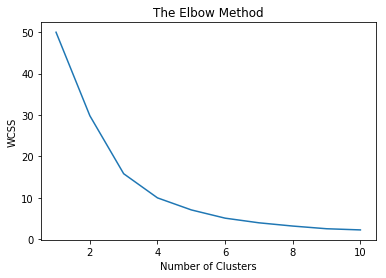

In [76]:
# create a loop to obtain the list of sum of squares
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(standardized_data)
    wcss.append(kmeans.inertia_)
    
# create a plot to view the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

### Applying k-means to Neighborhoods Dataset

The optimal number of clusters is the value on the x-axis at the point of the elbow.

In [77]:
# set number of clusters
num_clusters = 4

# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters=num_clusters, random_state=0, n_init = 12).fit(standardized_data)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([0, 3, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2,
       2, 0])

### Visualising the clusters

In [78]:
# add the cluster_labels array to the final df
final_df['Cluster Label'] = labels
final_df

,Area Name,Population 15 - 65 Yrs,Number of Gyms,Potential Customers,Rent EUR/sqm,Cluster Label
0,Altstadt - Lehel,15337.0,0.0,15337,15.3,0
1,Ludwigsvorstadt - Isarvorstadt,40440.0,0.0,40440,16.4,3
2,Maxvorstadt,40749.0,1.0,20374,15.2,0
3,Schwabing - West,49129.0,0.0,49129,15.2,3
4,Au - Haidhausen,44828.0,2.0,14942,15.1,0
5,Sendling,30292.0,2.0,10097,14.0,0
6,Sendling - Westpark,40967.0,1.0,20483,13.0,2
7,Schwanthalerhöhe,22291.0,0.0,22291,15.2,0
8,Neuhausen - Nymphenburg,69938.0,2.0,23312,15.1,0
9,Moosach,36838.0,2.0,12279,14.0,0


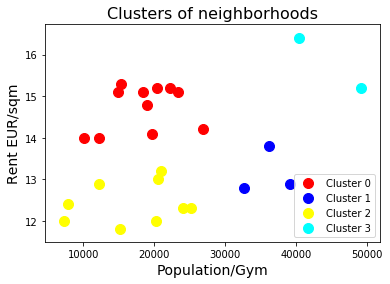

In [79]:
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], s = 100, c = 'red', label = 'Cluster 0')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(X[labels == 2, 0], X[labels == 2, 1], s = 100, c = 'yellow', label = 'Cluster 2')
plt.scatter(X[labels == 3, 0], X[labels == 3, 1], s = 100, c = 'cyan', label = 'Cluster 3')

#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of neighborhoods', fontsize=16)
plt.xlabel('Population/Gym', fontsize=14)
plt.ylabel('Rent EUR/sqm', fontsize=14)
plt.legend()

plt.show()

### Observation

The neighborhoods have been divided into four clusters. They are distinguished by the number of potential customers the new gym could receive and the wealthiness of the area represented by the average rent. 

Cluster 0 - depicts areas with higher rent, so obviously wealthy neighborhoods that cater for luxury gyms with high membership fees, the density is 10 to 30 k potential customers per gym.

Cluster 1 - the neighborhoods here are of lower to medium affluence, with 33 - 40k population per gym density. This seems to be an ideal cluster to target if we want to open up a rather simple gym with average membership fees.

Cluster 2 - shows the neighborhoods with lower rent with the population to gym density ranging from 8 to 27 k. Simple, no-frill gyms with lower membership fees can be found here.

Cluster 3 - the smallest cluster with the highest proportion of potential customers per gym (40 to 50k). Also an area with the top private property rent. This is the cluster to target, as there could be a high demand that has not been saturated yet. These are the high income areas, perfect for setting up an upscale gym.

## Recommendation

If somebody was to invest into opening a new gym, I would recommend to target the areas in Cluster 1 and 3. The clusters contain the following 5 neighborhoods:

In [89]:
recommendation = final_df[(final_df['Cluster Label'] == 1) | (final_df['Cluster Label'] == 3)]
recommendation

,Area Name,Population 15 - 65 Yrs,Number of Gyms,Potential Customers,Rent EUR/sqm,Cluster Label
1,Ludwigsvorstadt - Isarvorstadt,40440.0,0.0,40440,16.4,3
3,Schwabing - West,49129.0,0.0,49129,15.2,3
16,Obergiesing - Fasangarten,39182.0,0.0,39182,12.9,1
17,Untergiesing - Harlaching,36244.0,0.0,36244,13.8,1
19,Hadern,32602.0,0.0,32602,12.8,1


We see that there are no gyms in these neighbhorhoods so the market is not saturated yet.

Areas Ludwigsvorstadt - Isarvorstadt and Schwabing - West are the most affluent with high rent so we can expect that people living there have a high income but running a gym there would be therefore expensive. It would be an area of interest for luxury gym operators who can offer spacious gym sites with additional services such as sauna, pool, massage and childminding facilities.

Untergiesing - Harlaching is an area with an average rent so here I would recommend to open up a moderately expensive gym that could cater for middle-class customers.

The remaining two areas (Obergiesing - Fasangarten, Hadern) would represent lower income population. Opening a convenient simple gym with reasonable membership fees would be the best solution here.